# Prueba de múltiples modelos con mlflow


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 3, Finished, Available, Finished)

In [10]:
dffeatures = spark.sql("""select driverId,constructorId,year,round,grid,constructortotalpoints,constructorposition,
    drivertotalpoints,driverposition,currentraceposition,statusId,age 
    from features where year >2014 and year < 2024
""")

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 12, Finished, Available, Finished)

In [11]:
# Verificar el tipo de dato de cada columna
print(dffeatures.dtypes)

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 13, Finished, Available, Finished)

[('driverId', 'int'), ('constructorId', 'int'), ('year', 'int'), ('round', 'int'), ('grid', 'int'), ('constructortotalpoints', 'double'), ('constructorposition', 'int'), ('drivertotalpoints', 'double'), ('driverposition', 'int'), ('currentraceposition', 'string'), ('statusId', 'int'), ('age', 'int')]


In [13]:
dffeatures = dffeatures.to_pandas_on_spark()

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 15, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py:5723: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


In [14]:
# convertir los datos a numeros para poder ingresarlos a los modelos
dffeatures = dffeatures.astype(int)

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 16, Finished, Available, Finished)

In [15]:
dffeatures.dtypes

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 17, Finished, Available, Finished)

driverId                  int64
constructorId             int64
year                      int64
round                     int64
grid                      int64
constructortotalpoints    int64
constructorposition       int64
drivertotalpoints         int64
driverposition            int64
currentraceposition       int64
statusId                  int64
age                       int64
dtype: object

In [16]:
# Verificar el tamaño de la tabla
print(dffeatures.shape)

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 18, Finished, Available, Finished)

(3716, 12)


In [17]:
# Contar la cantidad de valores únicos por columna
print(dffeatures.nunique())

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 19, Finished, Available, Finished)

driverId                   50
constructorId              17
year                        9
round                      22
grid                       23
constructortotalpoints    420
constructorposition        11
drivertotalpoints         332
driverposition             24
currentraceposition        22
statusId                   61
age                        25
dtype: int64


In [18]:
# Contar la frecuencia de los valores en una columna
print(dffeatures['currentraceposition'].value_counts())

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 20, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


6     185
9     185
5     185
1     185
3     185
8     185
11    185
2     185
4     185
7     184
10    184
12    183
13    179
14    174
15    162
16    142
17    121
18     76
19     38
20     16
21      4
22      2
Name: currentraceposition, dtype: int64


Análisis de los campos Features

In [19]:
display(dffeatures,summary=True)

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 21, Finished, Available, Finished)

,driverId,constructorId,year,round,grid,constructortotalpoints,constructorposition,drivertotalpoints,driverposition,currentraceposition,statusId,age
0,154,210,2018,14,6,76,5,27,14,NaN,2,32
1,154,208,2015,1,8,0,9,0,14,NaN,75,29
2,8,6,2017,15,0,385,2,138,5,NaN,84,38
3,822,3,2015,1,0,12,4,0,18,NaN,54,26
4,154,210,2016,20,7,29,8,29,13,NaN,54,30
5,20,6,2016,2,3,33,2,15,6,NaN,5,29
6,832,1,2020,7,7,68,3,23,11,NaN,43,26
7,844,6,2021,5,1,78,4,40,6,NaN,30,24
8,844,6,2023,20,0,362,3,170,7,NaN,5,26
9,817,9,2018,2,4,20,4,12,8,NaN,10,29


-----

In [20]:
dffeatures= dffeatures.to_pandas()

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 22, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [21]:
dffeatures.head()

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 23, Finished, Available, Finished)

,driverId,constructorId,year,round,grid,constructortotalpoints,constructorposition,drivertotalpoints,driverposition,currentraceposition,statusId,age
0,154,210,2018,14,6,76,5,27,14,NaN,2,32
1,154,208,2015,1,8,0,9,0,14,NaN,75,29
2,8,6,2017,15,0,385,2,138,5,NaN,84,38
3,822,3,2015,1,0,12,4,0,18,NaN,54,26
4,154,210,2016,20,7,29,8,29,13,NaN,54,30


In [22]:
np.isnan(dffeatures['currentraceposition'])

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 24, Finished, Available, Finished)

0       True
1       True
2       True
3       True
4       True
        ... 
3711    True
3712    True
3713    True
3714    True
3715    True
Name: currentraceposition, Length: 3716, dtype: bool

In [25]:
# asignar el puesto hipotético nº 30 a los pilotos que no terminaron las carreras
dffeatures['currentraceposition'] = dffeatures['currentraceposition'].fillna(30)

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 27, Finished, Available, Finished)

In [26]:
dffeatures.head()

StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 28, Finished, Available, Finished)

,driverId,constructorId,year,round,grid,constructortotalpoints,constructorposition,drivertotalpoints,driverposition,currentraceposition,statusId,age
0,154,210,2018,14,6,76,5,27,14,30.0,2,32
1,154,208,2015,1,8,0,9,0,14,30.0,75,29
2,8,6,2017,15,0,385,2,138,5,30.0,84,38
3,822,3,2015,1,0,12,4,0,18,30.0,54,26
4,154,210,2016,20,7,29,8,29,13,30.0,54,30


**Configuración del experimento de aprendizaje automático en Microsoft Fabric**

In [27]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from mlflow.models.signature import infer_signature

# Configurar el experimento
mlflow.set_experiment("2014_23_features_rfc")

# Definir las características (X) y la variable objetivo (y)
X = dffeatures.drop(columns=['currentraceposition'])  # Características
y = dffeatures['currentraceposition']  # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

depths= [5,7,9]

# Entrenar el modelo y registrar con MLFlow
for d in depths:
    with mlflow.start_run() as run:
        # Crear y entrenar el modelo
        model = RandomForestClassifier(max_depth=d, random_state=42)
        model.fit(X_train, y_train)

        # Hacer predicciones
        y_pred = model.predict(X_test)
        score = model.score(X_test, y_test)  # Calcular la precisión

        # Registrar la métrica y parámetros del modelo
        mlflow.log_metric("accuracy", score)
        mlflow.log_param("max_depth", d)
        mlflow.log_param("random_state", 42)

        # Guardar el modelo con el nombre "2014_23_features_rfc"
        signature = infer_signature(X_train, y_train)
        mlflow.sklearn.log_model(model, "2014_23_features_rfc", signature=signature)
        print("Modelo guardado con run_id=%s" % run.info.run_id)

        # Registrar el modelo en MLFlow para seguimiento futuro con el nombre "2014_23_features_rfc"
        mlflow.register_model(
            "runs:/{}/2014_23_features_rfc".format(run.info.run_id), "2014_23_features_rfc"
        )
        print("Todo listo")


StatementMeta(, 6b94e070-9ccc-4466-8714-9316afeca66b, 29, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distuti

Modelo guardado con run_id=f5c7992f-ecb3-4481-ae66-3a8529cb2a1f
Todo listo


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model '2014_23_features_rfc' already exists. Creating a new version of this model...
2024/09/13 18:38:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version

Modelo guardado con run_id=3b43f17e-07e9-498a-b8cf-89713e313598
Todo listo


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model '2014_23_features_rfc' already exists. Creating a new version of this model...
2024/09/13 18:38:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version

Modelo guardado con run_id=49bd3158-c38c-4df2-96d1-7a4aaccc132a
Todo listo


Cargar el modelo y realizar inferencias

In [11]:
import mlflow.sklearn

# Cargar el modelo registrado
modelo_cargado = mlflow.sklearn.load_model("models:/2014_23_features_rfc/4")

# Hacer predicciones
y_pred = modelo_cargado.predict(X_test)

# Mostrar las predicciones
print(y_pred)

StatementMeta(, , , Waiting, , Waiting)

[14.  6.  7. 14.  3. 10. 30.  3. 30. 11.  9. 11.  3. 10.  8.  4.  5.  5.
 11.  7. 30. 30.  5.  5.  4.  8.  2.  1. 30.  3. 12.  5. 30. 30.  5. 13.
 15.  6. 14. 11. 30. 16. 15.  8. 10. 14.  9.  2. 14.  9. 15.  7. 30. 16.
 11. 30. 30. 18.  2. 30.  8. 11. 11.  2.  6.  5.  9.  6.  5.  8. 13. 12.
 16. 11.  7. 30.  1. 30. 10. 30. 11.  7.  8. 13. 30. 14. 11. 30.  6. 14.
 15. 11.  4.  7.  3.  9.  4. 30.  8.  3. 15.  7.  4. 30.  4. 16.  8.  9.
  8. 14.  3.  9.  2. 11. 30. 11. 11. 11. 30.  7. 30. 30. 30.  8.  2.  5.
 18. 14. 13. 30.  6. 30. 14. 17. 13.  3. 10.  9. 30. 12.  7.  8. 16.  1.
  6. 30. 12. 14. 13.  5. 15. 15. 16.  6.  5.  7. 30.  1.  8. 30.  9.  9.
 13.  3.  8.  9. 30.  2.  7. 14.  4.  5.  5. 12. 11. 30.  3. 14.  5.  5.
  8. 30.  5. 14. 30. 30. 30. 30. 16.  3. 30.  6.  1.  2. 30.  2.  4. 13.
  5. 16. 18. 11.  7. 30. 11.  3. 11.  7. 11. 30.  2. 30.  8. 13.  3.  6.
 30.  1. 15.  4. 12.  5.  6.  9. 13.  3. 10.  3.  7.  6. 30. 11. 14.  1.
  5. 12.  3. 15. 14.  4.  2.  8. 10.  7.  8. 10.  4

StatementMeta(, , -1, Waiting, , Waiting)

StatementMeta(, , -1, Waiting, , Waiting)

-----


In [12]:
# Evaluar el modelo (precisión)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")

StatementMeta(, , , Waiting, , Waiting)

Precisión del modelo: 0.6519


StatementMeta(, , , Waiting, , Waiting)

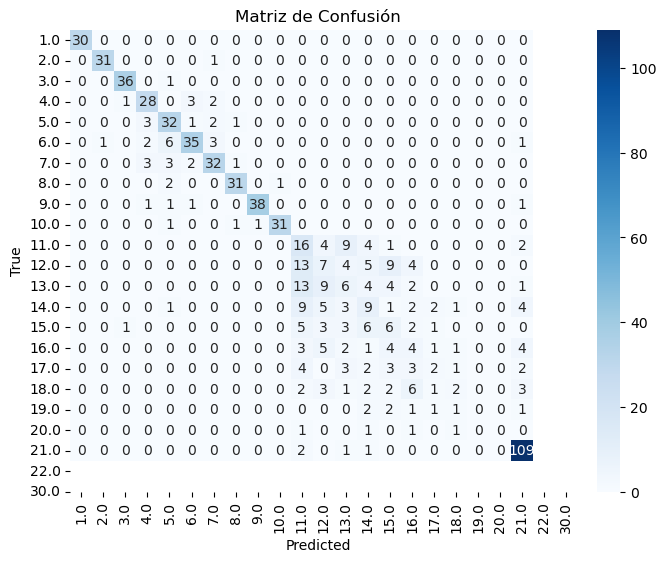

In [13]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

In [14]:
# Calcular la precisión global (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión global (Accuracy): {accuracy:.4f}")

# Calcular precision, recall, f1-score para cada clase
precision = precision_score(y_test, y_pred, average='weighted')  # Usa 'weighted' para multiclase
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precisión (Precision): {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Mostrar un informe completo
print("\nInforme de clasificación (Classification Report):")
print(classification_report(y_test, y_pred))

StatementMeta(, , , Waiting, , Waiting)

Precisión global (Accuracy): 0.6519
Precisión (Precision): 0.6391
Recall: 0.6519
F1-Score: 0.6401

Informe de clasificación (Classification Report):
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        30
         2.0       0.97      0.97      0.97        32
         3.0       0.95      0.97      0.96        37
         4.0       0.76      0.82      0.79        34
         5.0       0.68      0.82      0.74        39
         6.0       0.83      0.73      0.78        48
         7.0       0.80      0.78      0.79        41
         8.0       0.91      0.91      0.91        34
         9.0       0.97      0.90      0.94        42
        10.0       0.97      0.91      0.94        34
        11.0       0.24      0.44      0.31        36
        12.0       0.19      0.17      0.18        42
        13.0       0.19      0.15      0.17        39
        14.0       0.24      0.24      0.24        37
        15.0       0.19      0.22      0

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Análisis de correlación

StatementMeta(, , , Waiting, , Waiting)

                        driverId  constructorId      year     round      grid  \
driverId                1.000000      -0.072054  0.221818  0.007322  0.199444   
constructorId          -0.072054       1.000000  0.225741  0.007800  0.069607   
year                    0.221818       0.225741  1.000000  0.057437 -0.046457   
round                   0.007322       0.007800  0.057437  1.000000  0.004022   
grid                    0.199444       0.069607 -0.046457  0.004022  1.000000   
laps                   -0.025593       0.006169  0.043491 -0.000527 -0.060873   
constructortotalpoints -0.208237      -0.075677  0.044972  0.409528 -0.524034   
constructorposition     0.224734       0.139988 -0.013731  0.000290  0.686406   
drivertotalpoints      -0.238801      -0.075351  0.042423  0.397246 -0.529173   
driverposition          0.250003       0.132785 -0.017065  0.002209  0.693266   
currentracepoints      -0.234542      -0.068603  0.004861 -0.000593 -0.617719   
currentraceposition     0.12

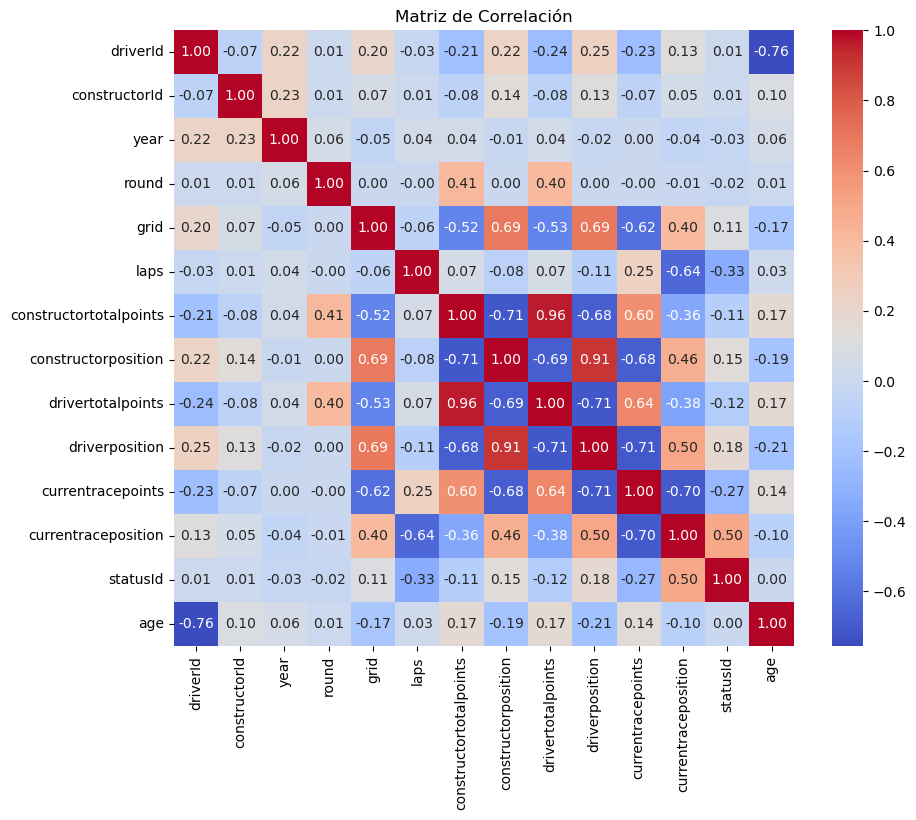

In [14]:
# Calcular la matriz de correlación
correlation_matrix = dffeatures.corr()

# Imprimir la matriz de correlación
print(correlation_matrix)

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

**Importancia de características**

In [15]:
# Obtener la importancia de características
importances = model.feature_importances_

# Crear un DataFrame para visualizar las características más importantes
import pandas as pd
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Ordenar las características por importancia de mayor a menor
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(feature_importances)

StatementMeta(, , , Waiting, , Waiting)

                   Feature  Importance
10       currentracepoints    0.396176
5                     laps    0.181757
11                statusId    0.089220
9           driverposition    0.059069
4                     grid    0.052520
8        drivertotalpoints    0.045062
7      constructorposition    0.042583
6   constructortotalpoints    0.034795
0                 driverId    0.022939
3                    round    0.022424
12                     age    0.020546
1            constructorId    0.017102
2                     year    0.015807


**Grid Search**

In [16]:
# Definir los hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200],           # Número de árboles
    'max_depth': [None, 5, 10, 20],           # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],          # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],            # Muestras mínimas por hoja
    'bootstrap': [True, False]                # Si se usa muestreo con reemplazo
}

# Instanciar el modelo RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Ajustar el modelo con los mejores hiperparámetros
grid_search.fit(X_train, y_train)

StatementMeta(, , , Waiting, , Waiting)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_sam

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_sa

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_sa

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_sam

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.3s


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_sam

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_lea

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_spl

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_s

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.9s


[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_spl

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s


[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_sp

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s


[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samp

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_sa

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.5s


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_sam

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, mi

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.4s


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, min_sam

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=No

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.8s


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.5s


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.5s


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=None,

[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s


[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s


[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s


[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min

[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samp

[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.2s


[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_

[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_

[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s


[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, m

[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s


[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_lea

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s


[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s


[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.6s


[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s


[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.4s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.6s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.2s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.5s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.4s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf

[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.7s


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [17]:
# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor score: {grid_search.best_score_:.4f}")

StatementMeta(, , , Waiting, , Waiting)

Mejores hiperparámetros: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Mejor score: 0.6767


In [18]:

# Ajustar el modelo con los mejores hiperparámetros
best_model = RandomForestClassifier(
    bootstrap=True,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=200,
    random_state=42
)

# Entrenar el modelo final
best_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la precisión
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

# Mostrar el informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))


StatementMeta(, , , Waiting, , Waiting)

Precisión en el conjunto de prueba: 0.6788

Informe de clasificación:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        30
         2.0       0.94      0.97      0.95        32
         3.0       0.97      0.97      0.97        37
         4.0       0.88      0.85      0.87        34
         5.0       0.86      0.92      0.89        39
         6.0       0.83      0.90      0.86        48
         7.0       0.95      0.93      0.94        41
         8.0       1.00      0.94      0.97        34
         9.0       0.95      0.90      0.93        42
        10.0       1.00      0.94      0.97        34
        11.0       0.23      0.39      0.29        36
        12.0       0.17      0.14      0.15        42
        13.0       0.17      0.15      0.16        39
        14.0       0.26      0.22      0.24        37
        15.0       0.14      0.11      0.12        27
        16.0       0.23      0.24      0.24        25
        17.

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

**Comparar el rendimiento en el conjunto de entrenamiento vs prueba:**

Si el rendimiento del modelo en el conjunto de entrenamiento es muy similar o incluso más alto que en el conjunto de prueba, podría indicar sobreajuste. Un modelo sobreajustado memoriza los datos de entrenamiento, lo que lleva a un rendimiento alto en el entrenamiento pero puede fallar en generalizar para nuevos datos.

In [19]:
# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Precisión en el conjunto de entrenamiento: {train_accuracy:.4f}")

# Evaluar el modelo en el conjunto de prueba
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")


StatementMeta(, , , Waiting, , Waiting)

Precisión en el conjunto de entrenamiento: 0.9418
Precisión en el conjunto de prueba: 0.6788


**Validación cruzada:**
Ya hiciste un ajuste de hiperparámetros con validación cruzada, lo cual es útil para evitar el sobreajuste. Sin embargo, puedes verificar si el modelo generaliza bien realizando nuevamente la validación cruzada con los mejores hiperparámetros y comparando el rendimiento entre las diferentes particiones.

In [20]:
# Realizar validación cruzada
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Promedio de validación cruzada: {cv_scores.mean():.4f}")

StatementMeta(, , , Waiting, , Waiting)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Puntajes de validación cruzada: [0.65042017 0.6907563  0.67845118 0.67676768 0.68350168]
Promedio de validación cruzada: 0.6760


------

**Reducción de características o evaluación sin points**

Dado que points tiene una correlación fuerte con la variable objetivo y es la característica más importante, podrías considerar realizar un experimento eliminando points del conjunto de datos y ver cómo afecta el rendimiento del modelo. Esto podría ayudar a determinar si el modelo está sobreajustado o si realmente está encontrando patrones útiles en las otras características.

In [15]:
# Eliminar la columna 'currentracepoints' del conjunto de entrenamiento y prueba
X_train_sin_points = X_train.drop(columns=['currentracepoints'])
X_test_sin_points = X_test.drop(columns=['currentracepoints'])

# Entrenar nuevamente el modelo sin 'currentracepoints'
model_sin_points = RandomForestClassifier(random_state=42)
model_sin_points.fit(X_train_sin_points, y_train)

# Evaluar el modelo en el conjunto de prueba sin 'points'
y_pred_sin_points = model_sin_points.predict(X_test_sin_points)
accuracy_sin_points = accuracy_score(y_test, y_pred_sin_points)

# Mostrar los resultados
print(f"Precisión del modelo sin 'points': {accuracy_sin_points:.4f}")



StatementMeta(, , , Waiting, , Waiting)

Precisión del modelo sin 'points': 0.3320


StatementMeta(, , , Waiting, , Waiting)

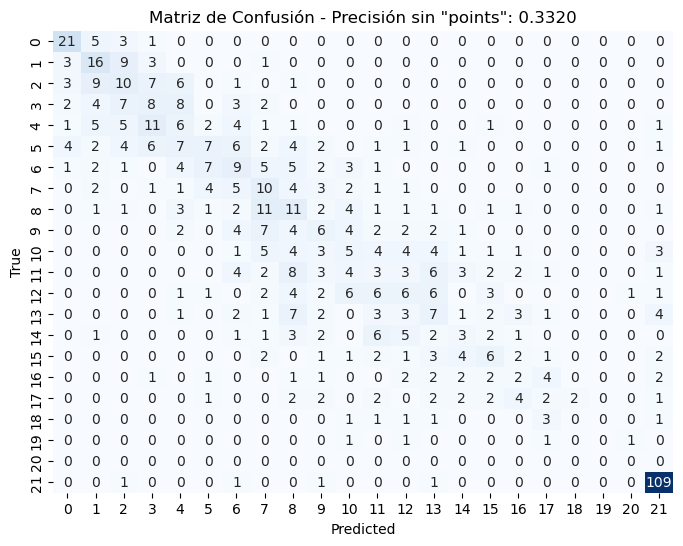

In [16]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_sin_points)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matriz de Confusión - Precisión sin "points": {accuracy_sin_points:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
# Calcular la precisión global (accuracy) para el modelo sin 'points'
accuracy_sin_points = accuracy_score(y_test, y_pred_sin_points)
print(f"Precisión global (Accuracy) sin 'points': {accuracy_sin_points:.4f}")

# Calcular precision, recall, f1-score para cada clase
precision_sin_points = precision_score(y_test, y_pred_sin_points, average='weighted')  # Usa 'weighted' para multiclase
recall_sin_points = recall_score(y_test, y_pred_sin_points, average='weighted')
f1_sin_points = f1_score(y_test, y_pred_sin_points, average='weighted')

print(f"Precisión (Precision) sin 'points': {precision_sin_points:.4f}")
print(f"Recall sin 'points': {recall_sin_points:.4f}")
print(f"F1-Score sin 'points': {f1_sin_points:.4f}")

# Mostrar un informe completo
print("\nInforme de clasificación (Classification Report) sin 'points':")
print(classification_report(y_test, y_pred_sin_points))

**Grid Search sin points**

In [25]:
# Definir los hiperparámetros a probar en GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],           # Número de árboles
    'max_depth': [None, 5, 10, 20],           # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],          # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],            # Muestras mínimas por hoja
    'bootstrap': [True, False]                # Si se usa muestreo con reemplazo
}

# Instanciar el modelo RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo con GridSearch
grid_search.fit(X_train_sin_points, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor precisión durante la validación cruzada: {grid_search.best_score_:.4f}")

# Evaluar el modelo en el conjunto de prueba
y_pred_sin_points = grid_search.best_estimator_.predict(X_test_sin_points)
accuracy_sin_points = accuracy_score(y_test, y_pred_sin_points)

# Mostrar la precisión en el conjunto de prueba
print(f"Precisión del modelo sin 'points' en el conjunto de prueba: {accuracy_sin_points:.4f}")

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 27, Finished, Available, Finished)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

In [26]:
# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor precisión durante la validación cruzada: {grid_search.best_score_:.4f}")

# Mostrar la precisión en el conjunto de prueba
print(f"Precisión del modelo sin 'points' en el conjunto de prueba: {accuracy_sin_points:.4f}")

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 28, Finished, Available, Finished)

Mejores hiperparámetros: {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mejor precisión durante la validación cruzada: 0.5171
Precisión del modelo sin 'points' en el conjunto de prueba: 0.4896


Probando otros valores para entrenar el modelo

In [33]:
# Definir los hiperparámetros a probar aleatoriamente
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Búsqueda aleatoria
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=2, n_jobs=-1)

random_search.fit(X_train_sin_points, y_train)

# Evaluar el modelo con los mejores hiperparámetros
y_pred = random_search.best_estimator_.predict(X_test_sin_points)
accuracy = accuracy_score(y_test, y_pred)
print(f"Mejor precisión después de RandomizedSearch: {accuracy:.4f}")

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 35, Finished, Available, Finished)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=14, n_estimators=213; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=14, n_estimators=213; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=14, n_estimators=213; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=14, n_estimators=213; total time=   1.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=14, n_estimators=213; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=158; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=158; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=158; total time

In [34]:
print(f"Mejor precisión después de RandomizedSearch: {accuracy:.4f}")

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 36, Finished, Available, Finished)

Mejor precisión después de RandomizedSearch: 0.5000


El modelo entrenado con RandomizedSearchCV obtuvo una precisión de 0.5000 en el conjunto de prueba. Aunque es una ligera mejora con respecto a las iteraciones anteriores, la precisión sigue siendo baja. Esto sugiere que, a pesar de los ajustes en los hiperparámetros, el modelo tiene dificultades para capturar las relaciones clave sin la variable points. Es posible que la estructura actual de las características no sea suficiente para mejorar el rendimiento significativamente, lo que refuerza la importancia de la variable excluida o de generar nuevas características derivadas.


**Entrenar otros modelos**

**Gradient Boosting Machines (GBM)**

Los modelos de boosting suelen funcionar mejor que los Random Forest en muchos problemas de clasificación, especialmente cuando hay características con interacciones complejas. Dos de los más populares son XGBoost y LightGBM.



**LightGBM**

In [25]:
import lightgbm as lgb

# Entrenar el modelo LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_lgb = lgb_model.predict(X_test_sin_points)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f"Precisión del modelo LightGBM: {accuracy_lgb:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 27, Finished, Available, Finished)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 9
[LightGBM] [Info] Start training from score -1.099729
[LightGBM] [Info] Start training from score -1.097497
[LightGBM] [Info] Start training from score -1.098612
Precisión del modelo LightGBM: 0.4554


**Support Vector Machines (SVM)**

Los Support Vector Machines (SVM) son excelentes para problemas con fronteras de decisión complejas. Son efectivos para conjuntos de datos con características limitadas y pueden manejar bien problemas de clasificación multiclase.



In [20]:
# Entrenar el modelo SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_svm = svm_model.predict(X_test_sin_points)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Precisión del modelo SVM: {accuracy_svm:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 22, Finished, Available, Finished)

Precisión del modelo SVM: 0.3616


**Redes Neuronales (Multilayer Perceptron - MLP)**

Un MLP (Multilayer Perceptron) es una red neuronal básica de tipo feedforward. Las redes neuronales son más flexibles y pueden aprender patrones complejos, aunque requieren un ajuste cuidadoso de los hiperparámetros.



In [21]:
from sklearn.neural_network import MLPClassifier

# Entrenar el modelo MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_mlp = mlp_model.predict(X_test_sin_points)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Precisión del modelo MLP: {accuracy_mlp:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 23, Finished, Available, Finished)

Precisión del modelo MLP: 0.3988


**K-Nearest Neighbors (KNN)**

El KNN es un modelo basado en instancias que clasifica un punto basándose en la clase de sus vecinos más cercanos. Es simple, pero puede ser muy efectivo si las características están bien separadas.



In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Entrenar el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_knn = knn_model.predict(X_test_sin_points)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Precisión del modelo KNN: {accuracy_knn:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 24, Finished, Available, Finished)

Precisión del modelo KNN: 0.3884


**Naive Bayes**

El modelo de Naive Bayes es un clasificador probabilístico que asume que las características son independientes entre sí. Aunque esta suposición es a menudo poco realista, el modelo puede ser rápido y efectivo en algunos problemas.



In [23]:
from sklearn.naive_bayes import GaussianNB

# Entrenar el modelo Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_nb = nb_model.predict(X_test_sin_points)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Precisión del modelo Naive Bayes: {accuracy_nb:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 25, Finished, Available, Finished)

Precisión del modelo Naive Bayes: 0.3839


**Logistic Regression**

La Regresión Logística es un modelo simple y efectivo para la clasificación binaria y multiclase. A veces puede ser más eficaz que modelos más complejos, sobre todo si las características no son altamente no lineales.



In [24]:
from sklearn.linear_model import LogisticRegression

# Entrenar el modelo de Regresión Logística
log_model = LogisticRegression(max_iter=500, random_state=42)
log_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_log = log_model.predict(X_test_sin_points)
accuracy_log = accuracy_score(y_test, y_pred_log)
print(f"Precisión del modelo Regresión Logística: {accuracy_log:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 26, Finished, Available, Finished)

Precisión del modelo Regresión Logística: 0.4732


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Crear el modelo de regresión logística multiclase
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
lr_model.fit(X_train_sin_points, y_train)

# Hacer predicciones en los datos de prueba
y_pred = lr_model.predict(X_test_sin_points)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo de Regresión Logística: {accuracy:.4f}")

# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# Mostrar el informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 28, Finished, Available, Finished)

Precisión del modelo de Regresión Logística: 0.4762
Matriz de Confusión:
[[159  37  25]
 [114  59  51]
 [ 57  68 102]]
Informe de clasificación:
              precision    recall  f1-score   support

           1       0.48      0.72      0.58       221
           2       0.36      0.26      0.30       224
           3       0.57      0.45      0.50       227

    accuracy                           0.48       672
   macro avg       0.47      0.48      0.46       672
weighted avg       0.47      0.48      0.46       672



/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
